In [4]:
import pandas as pd
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
df=pd.read_csv('/Users/Keisuke/Desktop/bigtable.csv')

In [6]:
df=df.drop(['Unnamed: 0','t-1yr_unemp_rate','t-1school_yr_unemp_rate'], axis=1)


In [7]:
l = []
for val in df.columns.tolist():
    if '0.0' in val:
        l.append(val)
        df = df.drop(val, axis=1)
len(l)

28

In [8]:
l

['third_read_pl_0.0',
 'third_math_pl_0.0',
 'fourth_read_pl_0.0',
 'fourth_math_pl_0.0',
 'fourth_write_pl_0.0',
 'fourth_ctz_pl_0.0',
 'fourth_science_pl_0.0',
 'fifth_read_pl_0.0',
 'fifth_math_pl_0.0',
 'fifth_socstudies_pl_0.0',
 'fifth_science_pl_0.0',
 'sixth_read_pl_0.0',
 'sixth_math_pl_0.0',
 'sixth_write_pl_0.0',
 'sixth_ctz_pl_0.0',
 'sixth_science_pl_0.0',
 'seventh_read_pl_0.0',
 'seventh_math_pl_0.0',
 'seventh_write_pl_0.0',
 'eighth_read_pl_0.0',
 'eighth_math_pl_0.0',
 'eighth_science_pl_0.0',
 'eighth_socstudies_pl_0.0',
 'ogt_read_pl_0.0',
 'ogt_math_pl_0.0',
 'ogt_write_pl_0.0',
 'ogt_science_pl_0.0',
 'ogt_socstudies_pl_0.0']

In [9]:
len(df.columns.tolist())

219

In [10]:


def split_train_test(dataset, ith_grade, test_year):
    """
    transform dataset into suitable one for specific grade students
    
    input
        dataset: dataframe
        ith_grade: the target current (or base) grade for analysis (integer)
        test_year: testing data's year (integer)      
    output
        dataframe
    """
        
    final_grade = 12
    duration = final_grade - ith_grade + 1

    if test_year <= 2009:
        print("""We have no enough training data.
              Please set school year from 2010.""")
        return None, None, None, None

    max_year = dataset['school_year'].max()
    
    if test_year + duration  > max_year:
        print("""We have no enough school year for testing data.
              Please set school year before {}.""".format(max_year - duration + 2))
        return None, None, None, None
    
    ### create keep_col
    
    all_cols = dataset.columns.values.tolist()
    district_cols = [col for col in all_cols if 'district' in col]
    disability_cols = [col for col in all_cols if 'disability' in col]
    zip_cols = [col for col in all_cols if 'zip' in col]
    disadv_cols = [col for col in all_cols if 'disadvantagement' in col]
    change_cols = ['school_year', 'grade','age', 'discipline_incidents','retained',
               'log_median', 'log_mean', 'log_pop','log_median_miss', 'log_mean_miss', 'log_pop_miss',
                 'limited_english_Miss',
                 'limited_english_f', 'limited_english_t', 'gifted_Miss',
                 'gifted_f','gifted_t','total_length_of_absence',
                 'length_of_unexcused_absence', 'absence_ratio',
                 'unexcused_absence_ratio', 'diff_total_length_of_absence',
                 'diff_length_of_unexcused_absence', 'diff_absence_ratio',
                 'diff_unexcused_absence_ratio', 'absence_consec_count',
                 'diff_absence_consec_count', 'absence_medical',
                 'diff_absence_medical', 'absence_suspension',
                 'diff_absence_suspension','days_tardy',
                 'diff_days_tardy', 'unexcused tardy', 'diff_unexcused tardy',
                 'tardy_consec_count', 'diff_tardy_consec_count',
                 'unemp_rate', 't-1yr_unemp_rate', 'school_yr_unemp_rate',
                 't-1school_yr_unemp_rate', 'dropout_prevention',
                 'special_education', 'extra_program', 'advanced_program',
                 'other_program', 'family_school_career_program', 'missing_intervention',
                 'gpa_est','gpa_miss']
    change_cols = change_cols + district_cols + disability_cols + zip_cols + disadv_cols
    keep_cols = [x for x in all_cols if x not in change_cols]
    
    x_train = train_x_transform(dataset, ith_grade, test_year, keep_cols=keep_cols)
    y_train = train_y_transform(dataset, ith_grade, test_year)
        
    x_test = test_x_transform(dataset, ith_grade, test_year, keep_cols=keep_cols)
    y_test = test_y_transform(dataset, ith_grade, test_year)

    return  x_train, x_test, y_train, y_test



def train_x_transform(dataset, ith_grade, test_year, keep_cols=['student_lookup']):
    """
    transform dataset into suitable one for specific grade students
    
    input
        dataset: dataframe
        ith_grade: the target grade for analysis (integer)
        test_year: testing data's year (integer)              
        keep_cols: list of columns' names that you don't want to create by grade (default 'student_lookup')
                   <CAUTION> Do not include either 'dropout', 'school_year' or 'grade'
                             and you should include something plus 'student_lookup'      
    output
        dataframe
    """
    dataset = dataset.drop('dropout', axis =1)
    cols = dataset.columns.values.tolist()
    if 'grade' in cols:
        cols.remove('grade')
    if 'dropout' in keep_cols:
        keep_cols.remove('dropout')
    if 'grade' in keep_cols:
        keep_cols.remove('grade')    
    for col in keep_cols:
        cols.remove(col)
    
    final_grade = 12
    duration = final_grade - ith_grade + 1
    
    sid_df = dataset[(dataset.grade == ith_grade)&(dataset.school_year <= test_year - duration)][['student_lookup']]
    df_ith = dataset[dataset.student_lookup.isin(sid_df.student_lookup)]
    new_dataset = df_ith[(dataset.grade <= ith_grade)&(dataset.grade >= ith_grade - 3)]
    new_dataset = new_dataset.reset_index()  
    pivot_df = pd.pivot_table(new_dataset, 
                              values=cols, 
                              index=keep_cols,
                              columns=['grade'])
    pivot_df.columns = [s1 +'_'+ str(s2)+'th' for (s1,s2) in pivot_df.columns.tolist()]
    pivot_df.reset_index(inplace=True)
    
    for col in pivot_df.columns.values:
        if 'miss' in col or 'Miss' in col or 'zip_0' in col:
            pivot_df[col].fillna(1, inplace=True)
        else:
            pivot_df[col].fillna(0, inplace=True)
            
    ### avoid duplication with x_data
    for col in pivot_df.columns.tolist():
        if 'school_year' in col:
            pivot_df = pivot_df.drop(col, axis=1)
        
    pivot_df = pivot_df.drop('student_lookup', axis=1)
    return pivot_df



def train_y_transform(dataset, ith_grade, test_year):
    """
    transform dataset into suitable one for specific grade students
    
    input
        dataset: dataframe
        ith_grade: the target grade for analysis (integer)
        test_year: testing data's year (integer)      
        
    output
        dataframe
    """
    dataset = dataset[['student_lookup', 'grade', 'school_year', 'dropout']]
    cols = ['school_year', 'dropout']
 
    
    final_grade = 12
    duration = final_grade - ith_grade + 1

    sid_df = dataset[(dataset.grade == ith_grade)&(dataset.school_year <= test_year - duration)][['student_lookup']]
    df_ith = dataset[dataset.student_lookup.isin(sid_df.student_lookup)]
    new_dataset = df_ith[dataset.grade >= ith_grade]
    new_dataset = new_dataset.reset_index()  
    pivot_df = pd.pivot_table(new_dataset, 
                              values=cols, 
                              index=['student_lookup'],
                              columns=['grade'])
    pivot_df.columns = [s1 +'_'+ str(s2)+'th' for (s1,s2) in pivot_df.columns.tolist()]
    pivot_df.reset_index(inplace=True)
    
    ### avoid duplication with x_data
    for col in pivot_df.columns.tolist():
        if 'school_year' in col:
            pivot_df = pivot_df.drop(col, axis=1)
            
    ### fill nan in the dropout column with the previous year information by student             
    for i in range(pivot_df.shape[0]):
        for j in range(2, pivot_df.shape[1]):
            cell = pivot_df.iat[i, j]
            cell = cell.astype(str)
            if cell == 'nan':
                pivot_df.iat[i, j] = pivot_df.iat[i, j-1]
                
    ### fix label value error cuased by duplication                            
    for i in range(pivot_df.shape[0]):
        for j in range(pivot_df.shape[1]):
            cell = pivot_df.iat[i, j] 
            if cell > 0 and cell < 1:
                pivot_df.iat[i, j] = 1
                
    pivot_df = pivot_df[['student_lookup','dropout_12.0th']]

    pivot_df = pivot_df.drop('student_lookup', axis=1)
    return pivot_df.as_matrix().reshape(-1,)


def test_x_transform(dataset, ith_grade, test_year, keep_cols=['student_lookup']):
    """
    transform dataset into suitable one for specific grade students
    
    input
        dataset: dataframe
        ith_grade: the target grade for analysis (integer)
        keep_cols: list of columns' names that you don't want to create by grade (default 'student_lookup')
                   <CAUTION> Do not include either 'dropout', 'school_year' or 'grade'
                             and you should include something plus 'student_lookup'      
    output
        dataframe
    """
    dataset = dataset.drop('dropout', axis =1)
    cols = dataset.columns.values.tolist()
    if 'grade' in cols:
        cols.remove('grade')
    if 'dropout' in keep_cols:
        keep_cols.remove('dropout')
    if 'grade' in keep_cols:
        keep_cols.remove('grade')    
    for col in keep_cols:
        cols.remove(col)
    
    final_grade = 12
    duration = final_grade - ith_grade + 1

    sid_df = dataset[(dataset.grade == ith_grade)&(dataset.school_year <= test_year - duration)][['student_lookup']]
    df_ith = dataset[dataset.student_lookup.isin(sid_df.student_lookup)]
    new_dataset = df_ith[(dataset.grade <= ith_grade)&(dataset.grade >= ith_grade - 3)]
    new_dataset = new_dataset.reset_index()  
    pivot_df = pd.pivot_table(new_dataset, 
                              values=cols, 
                              index=keep_cols,
                              columns=['grade'])
    pivot_df.columns = [s1 +'_'+ str(s2)+'th' for (s1,s2) in pivot_df.columns.tolist()]
    pivot_df.reset_index(inplace=True)
    
    for col in pivot_df.columns.values:
        if 'miss' in col or 'Miss' in col or 'zip_0' in col:
            pivot_df[col].fillna(1, inplace=True)
        else:
            pivot_df[col].fillna(0, inplace=True)
            
    ### avoid duplication with x_data
    for col in pivot_df.columns.tolist():
        if 'school_year' in col:
            pivot_df = pivot_df.drop(col, axis=1)
        
    pivot_df = pivot_df.drop('student_lookup', axis=1)
    return pivot_df



def test_y_transform(dataset, ith_grade, test_year):
    """
    transform dataset into suitable one for specific grade students
    
    input
        dataset: dataframe
        ith_grade: the target grade for analysis (integer)
          
    output
        dataframe
    """
    dataset = dataset[['student_lookup', 'grade', 'school_year', 'dropout']]
    cols = ['school_year', 'dropout']
    
    final_grade = 12
    duration = final_grade - ith_grade + 1

    sid_df = dataset[(dataset.grade == ith_grade)&(dataset.school_year <= test_year - duration)][['student_lookup']]
    df_ith = dataset[dataset.student_lookup.isin(sid_df.student_lookup)]
    new_dataset = df_ith[dataset.grade >= ith_grade]
    new_dataset = new_dataset.reset_index()  
    pivot_df = pd.pivot_table(new_dataset, 
                              values=cols, 
                              index=['student_lookup'],
                              columns=['grade'])
    pivot_df.columns = [s1 +'_'+ str(s2)+'th' for (s1,s2) in pivot_df.columns.tolist()]
    pivot_df.reset_index(inplace=True)
    
    ### avoid duplication with x_data
    for col in pivot_df.columns.tolist():
        if 'school_year' in col:
            pivot_df = pivot_df.drop(col, axis=1)
            
    ### fill nan in the dropout column with the previous year information by student             
    for i in range(pivot_df.shape[0]):
        for j in range(2, pivot_df.shape[1]):
            cell = pivot_df.iat[i, j]
            cell = cell.astype(str)
            if cell == 'nan':
                pivot_df.iat[i, j] = pivot_df.iat[i, j-1]
                
    ### fix label value error cuased by duplication                            
    for i in range(pivot_df.shape[0]):
        for j in range(pivot_df.shape[1]):
            cell = pivot_df.iat[i, j] 
            if cell > 0 and cell < 1:
                pivot_df.iat[i, j] = 1
    pivot_df = pivot_df[['student_lookup','dropout_12.0th']]
    
    pivot_df = pivot_df.drop('student_lookup', axis=1)
    return pivot_df.as_matrix().reshape(-1,)

In [11]:
from sklearn.metrics import recall_score
def recall_get_feature_importance(train_x_data, train_y_data, test_x_data, test_y_data, model):
    """
    Borrowed from here
    http://www.dskomei.com/entry/2018/03/20/003752
    """
    from sklearn.ensemble import RandomForestClassifier

    col_names = train_x_data.columns.values

    ### model = SVC(kernel='rbf', C=1, gamma=0.1)

    selected_col_names = []
    scores = []
    selected_k = 0
    max_score = 0

    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_x_data, train_y_data)

    # sort by feature importance provided by RF
    col_names_ = col_names[np.argsort(rf.feature_importances_)[::-1]]

    for n_variable in range(1, len(col_names)+1):

        # select variables from top important one
        train_x_data_ = train_x_data.loc[:, col_names_[:n_variable]]
        test_x_data_ = test_x_data.loc[:, col_names_[:n_variable]]

        model.fit(train_x_data_, train_y_data)
        #score = model.score(test_x_data_, test_y_data)
        score = recall_score(test_y_data, model.predict(test_x_data_))

        if score > max_score:
            max_score = score
            selected_k = n_variable

        selected_col_names.append(','.join(col_names_[:n_variable]))
        scores.append(score)

        print('k {:3} : score {:5.2f}%'.format(n_variable, max_score * 100))

    print('')
    print('[MAX SCORE] : k {} : score {}%'.format(selected_k, max_score))
    print(selected_col_names[int(np.argmax(scores))])

In [12]:
x_train, x_test, y_train, y_test = split_train_test(df, 9, 2011)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:209: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:253: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [13]:
y_train.shape

(2570,)

In [14]:
x_train.shape

(2570, 662)

In [15]:
y_test.shape

(2570,)

In [16]:
x_test.shape

(2570, 662)

In [17]:
LR = LogisticRegression()
KNN = KNeighborsClassifier()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
BAG = BaggingClassifier()
AB = AdaBoostClassifier()
SVM = SVC(kernel='rbf')

In [15]:
recall_get_feature_importance(x_train, y_train, x_test, y_test, LR)

k   1 : score  0.00%
k   2 : score  2.44%
k   3 : score  2.44%
k   4 : score  2.44%
k   5 : score  2.44%
k   6 : score  2.44%
k   7 : score  2.44%
k   8 : score  2.44%
k   9 : score  2.44%
k  10 : score  2.44%
k  11 : score  4.88%
k  12 : score  4.88%
k  13 : score  4.88%
k  14 : score  4.88%
k  15 : score  4.88%
k  16 : score  4.88%
k  17 : score  4.88%
k  18 : score  4.88%
k  19 : score  4.88%
k  20 : score  4.88%
k  21 : score  4.88%
k  22 : score  4.88%
k  23 : score  4.88%
k  24 : score  4.88%
k  25 : score  4.88%
k  26 : score  4.88%
k  27 : score  4.88%
k  28 : score  4.88%
k  29 : score  4.88%
k  30 : score  4.88%
k  31 : score  4.88%
k  32 : score  4.88%
k  33 : score  4.88%
k  34 : score  4.88%
k  35 : score  4.88%
k  36 : score  4.88%
k  37 : score  4.88%
k  38 : score  4.88%
k  39 : score  4.88%
k  40 : score  4.88%
k  41 : score  4.88%
k  42 : score  4.88%
k  43 : score  4.88%
k  44 : score  4.88%
k  45 : score  4.88%
k  46 : score  4.88%
k  47 : score  4.88%
k  48 : score

k 392 : score  4.88%
k 393 : score  4.88%
k 394 : score  4.88%
k 395 : score  4.88%
k 396 : score  4.88%
k 397 : score  4.88%
k 398 : score  4.88%
k 399 : score  4.88%
k 400 : score  4.88%
k 401 : score  4.88%
k 402 : score  4.88%
k 403 : score  4.88%
k 404 : score  4.88%
k 405 : score  4.88%
k 406 : score  4.88%
k 407 : score  4.88%
k 408 : score  4.88%
k 409 : score  4.88%
k 410 : score  4.88%
k 411 : score  4.88%
k 412 : score  4.88%
k 413 : score  4.88%
k 414 : score  4.88%
k 415 : score  4.88%
k 416 : score  4.88%
k 417 : score  4.88%
k 418 : score  4.88%
k 419 : score  4.88%
k 420 : score  4.88%
k 421 : score  4.88%
k 422 : score  4.88%
k 423 : score  4.88%
k 424 : score  4.88%
k 425 : score  4.88%
k 426 : score  4.88%
k 427 : score  4.88%
k 428 : score  4.88%
k 429 : score  4.88%
k 430 : score  4.88%
k 431 : score  4.88%
k 432 : score  4.88%
k 433 : score  4.88%
k 434 : score  4.88%
k 435 : score  4.88%
k 436 : score  4.88%
k 437 : score  4.88%
k 438 : score  4.88%
k 439 : score

In [16]:
recall_get_feature_importance(x_train, y_train, x_test, y_test, DT)

k   1 : score  9.76%
k   2 : score 43.90%
k   3 : score 60.98%
k   4 : score 65.85%
k   5 : score 90.24%
k   6 : score 90.24%
k   7 : score 90.24%
k   8 : score 92.68%
k   9 : score 97.56%
k  10 : score 100.00%
k  11 : score 100.00%
k  12 : score 100.00%
k  13 : score 100.00%
k  14 : score 100.00%
k  15 : score 100.00%
k  16 : score 100.00%
k  17 : score 100.00%
k  18 : score 100.00%
k  19 : score 100.00%
k  20 : score 100.00%
k  21 : score 100.00%
k  22 : score 100.00%
k  23 : score 100.00%
k  24 : score 100.00%
k  25 : score 100.00%
k  26 : score 100.00%
k  27 : score 100.00%
k  28 : score 100.00%
k  29 : score 100.00%
k  30 : score 100.00%
k  31 : score 100.00%
k  32 : score 100.00%
k  33 : score 100.00%
k  34 : score 100.00%
k  35 : score 100.00%
k  36 : score 100.00%
k  37 : score 100.00%
k  38 : score 100.00%
k  39 : score 100.00%
k  40 : score 100.00%
k  41 : score 100.00%
k  42 : score 100.00%
k  43 : score 100.00%
k  44 : score 100.00%
k  45 : score 100.00%
k  46 : score 100.0

k 375 : score 100.00%
k 376 : score 100.00%
k 377 : score 100.00%
k 378 : score 100.00%
k 379 : score 100.00%
k 380 : score 100.00%
k 381 : score 100.00%
k 382 : score 100.00%
k 383 : score 100.00%
k 384 : score 100.00%
k 385 : score 100.00%
k 386 : score 100.00%
k 387 : score 100.00%
k 388 : score 100.00%
k 389 : score 100.00%
k 390 : score 100.00%
k 391 : score 100.00%
k 392 : score 100.00%
k 393 : score 100.00%
k 394 : score 100.00%
k 395 : score 100.00%
k 396 : score 100.00%
k 397 : score 100.00%
k 398 : score 100.00%
k 399 : score 100.00%
k 400 : score 100.00%
k 401 : score 100.00%
k 402 : score 100.00%
k 403 : score 100.00%
k 404 : score 100.00%
k 405 : score 100.00%
k 406 : score 100.00%
k 407 : score 100.00%
k 408 : score 100.00%
k 409 : score 100.00%
k 410 : score 100.00%
k 411 : score 100.00%
k 412 : score 100.00%
k 413 : score 100.00%
k 414 : score 100.00%
k 415 : score 100.00%
k 416 : score 100.00%
k 417 : score 100.00%
k 418 : score 100.00%
k 419 : score 100.00%
k 420 : sc

In [17]:
recall_get_feature_importance(x_train, y_train, x_test, y_test, AB)

k   1 : score  0.00%
k   2 : score  4.88%
k   3 : score  7.32%
k   4 : score  7.32%
k   5 : score  7.32%
k   6 : score  7.32%
k   7 : score  9.76%
k   8 : score 14.63%
k   9 : score 14.63%
k  10 : score 14.63%
k  11 : score 14.63%
k  12 : score 14.63%
k  13 : score 14.63%
k  14 : score 14.63%
k  15 : score 14.63%
k  16 : score 14.63%
k  17 : score 17.07%
k  18 : score 17.07%
k  19 : score 17.07%
k  20 : score 17.07%
k  21 : score 17.07%
k  22 : score 17.07%
k  23 : score 17.07%
k  24 : score 17.07%
k  25 : score 19.51%
k  26 : score 19.51%
k  27 : score 24.39%
k  28 : score 24.39%
k  29 : score 24.39%
k  30 : score 24.39%
k  31 : score 24.39%
k  32 : score 24.39%
k  33 : score 24.39%
k  34 : score 24.39%
k  35 : score 24.39%
k  36 : score 24.39%
k  37 : score 24.39%
k  38 : score 24.39%
k  39 : score 24.39%
k  40 : score 24.39%
k  41 : score 24.39%
k  42 : score 24.39%
k  43 : score 24.39%
k  44 : score 24.39%
k  45 : score 24.39%
k  46 : score 24.39%
k  47 : score 24.39%
k  48 : score

k 392 : score 24.39%
k 393 : score 24.39%
k 394 : score 24.39%
k 395 : score 24.39%
k 396 : score 24.39%
k 397 : score 24.39%
k 398 : score 24.39%
k 399 : score 24.39%
k 400 : score 24.39%
k 401 : score 24.39%
k 402 : score 24.39%
k 403 : score 24.39%
k 404 : score 24.39%
k 405 : score 24.39%
k 406 : score 24.39%
k 407 : score 24.39%
k 408 : score 24.39%
k 409 : score 24.39%
k 410 : score 24.39%
k 411 : score 24.39%
k 412 : score 24.39%
k 413 : score 24.39%
k 414 : score 24.39%
k 415 : score 24.39%
k 416 : score 24.39%
k 417 : score 24.39%
k 418 : score 24.39%
k 419 : score 24.39%
k 420 : score 24.39%
k 421 : score 24.39%
k 422 : score 24.39%
k 423 : score 24.39%
k 424 : score 24.39%
k 425 : score 24.39%
k 426 : score 24.39%
k 427 : score 24.39%
k 428 : score 24.39%
k 429 : score 24.39%
k 430 : score 24.39%
k 431 : score 24.39%
k 432 : score 24.39%
k 433 : score 24.39%
k 434 : score 24.39%
k 435 : score 24.39%
k 436 : score 24.39%
k 437 : score 24.39%
k 438 : score 24.39%
k 439 : score

In [18]:
recall_get_feature_importance(x_train, y_train, x_test, y_test, BAG)

k   1 : score  7.32%
k   2 : score 31.71%
k   3 : score 48.78%
k   4 : score 48.78%
k   5 : score 70.73%
k   6 : score 70.73%
k   7 : score 70.73%
k   8 : score 75.61%
k   9 : score 75.61%
k  10 : score 75.61%
k  11 : score 75.61%
k  12 : score 75.61%
k  13 : score 82.93%
k  14 : score 82.93%
k  15 : score 82.93%
k  16 : score 82.93%
k  17 : score 82.93%
k  18 : score 82.93%
k  19 : score 82.93%
k  20 : score 82.93%
k  21 : score 82.93%
k  22 : score 82.93%
k  23 : score 82.93%
k  24 : score 82.93%
k  25 : score 87.80%
k  26 : score 87.80%
k  27 : score 87.80%
k  28 : score 87.80%
k  29 : score 87.80%
k  30 : score 87.80%
k  31 : score 87.80%
k  32 : score 87.80%
k  33 : score 87.80%
k  34 : score 87.80%
k  35 : score 87.80%
k  36 : score 87.80%
k  37 : score 87.80%
k  38 : score 87.80%
k  39 : score 87.80%
k  40 : score 87.80%
k  41 : score 87.80%
k  42 : score 87.80%
k  43 : score 87.80%
k  44 : score 87.80%
k  45 : score 87.80%
k  46 : score 87.80%
k  47 : score 87.80%
k  48 : score

k 392 : score 92.68%
k 393 : score 92.68%
k 394 : score 92.68%
k 395 : score 92.68%
k 396 : score 92.68%
k 397 : score 92.68%
k 398 : score 92.68%
k 399 : score 92.68%
k 400 : score 92.68%
k 401 : score 92.68%
k 402 : score 92.68%
k 403 : score 92.68%
k 404 : score 92.68%
k 405 : score 92.68%
k 406 : score 92.68%
k 407 : score 92.68%
k 408 : score 92.68%
k 409 : score 92.68%
k 410 : score 92.68%
k 411 : score 92.68%
k 412 : score 92.68%
k 413 : score 92.68%
k 414 : score 92.68%
k 415 : score 92.68%
k 416 : score 92.68%
k 417 : score 92.68%
k 418 : score 92.68%
k 419 : score 92.68%
k 420 : score 92.68%
k 421 : score 92.68%
k 422 : score 92.68%
k 423 : score 92.68%
k 424 : score 92.68%
k 425 : score 92.68%
k 426 : score 92.68%
k 427 : score 92.68%
k 428 : score 92.68%
k 429 : score 92.68%
k 430 : score 92.68%
k 431 : score 92.68%
k 432 : score 92.68%
k 433 : score 92.68%
k 434 : score 92.68%
k 435 : score 92.68%
k 436 : score 92.68%
k 437 : score 92.68%
k 438 : score 92.68%
k 439 : score

In [33]:
recall_get_feature_importance(x_train, y_train, x_test, y_test, RF)

k   1 : score 12.20%
k   2 : score 34.15%
k   3 : score 43.90%
k   4 : score 51.22%
k   5 : score 68.29%
k   6 : score 73.17%
k   7 : score 73.17%
k   8 : score 73.17%
k   9 : score 73.17%
k  10 : score 73.17%
k  11 : score 82.93%
k  12 : score 82.93%
k  13 : score 82.93%
k  14 : score 82.93%
k  15 : score 82.93%
k  16 : score 82.93%
k  17 : score 85.37%
k  18 : score 85.37%
k  19 : score 85.37%
k  20 : score 85.37%
k  21 : score 85.37%
k  22 : score 85.37%
k  23 : score 85.37%
k  24 : score 85.37%
k  25 : score 85.37%
k  26 : score 85.37%
k  27 : score 85.37%
k  28 : score 85.37%
k  29 : score 85.37%
k  30 : score 85.37%
k  31 : score 85.37%
k  32 : score 85.37%
k  33 : score 85.37%
k  34 : score 90.24%
k  35 : score 90.24%
k  36 : score 90.24%
k  37 : score 90.24%
k  38 : score 90.24%
k  39 : score 90.24%
k  40 : score 90.24%
k  41 : score 90.24%
k  42 : score 90.24%
k  43 : score 90.24%
k  44 : score 90.24%
k  45 : score 90.24%
k  46 : score 90.24%
k  47 : score 90.24%
k  48 : score

k 392 : score 90.24%
k 393 : score 90.24%
k 394 : score 90.24%
k 395 : score 90.24%
k 396 : score 90.24%
k 397 : score 90.24%
k 398 : score 90.24%
k 399 : score 90.24%
k 400 : score 90.24%
k 401 : score 90.24%
k 402 : score 90.24%
k 403 : score 90.24%
k 404 : score 90.24%
k 405 : score 90.24%
k 406 : score 90.24%
k 407 : score 90.24%
k 408 : score 90.24%
k 409 : score 90.24%
k 410 : score 90.24%
k 411 : score 90.24%
k 412 : score 90.24%
k 413 : score 90.24%
k 414 : score 90.24%
k 415 : score 90.24%
k 416 : score 90.24%
k 417 : score 90.24%
k 418 : score 90.24%
k 419 : score 90.24%
k 420 : score 90.24%
k 421 : score 90.24%
k 422 : score 90.24%
k 423 : score 90.24%
k 424 : score 90.24%
k 425 : score 90.24%
k 426 : score 90.24%
k 427 : score 90.24%
k 428 : score 90.24%
k 429 : score 90.24%
k 430 : score 90.24%
k 431 : score 90.24%
k 432 : score 90.24%
k 433 : score 90.24%
k 434 : score 90.24%
k 435 : score 90.24%
k 436 : score 90.24%
k 437 : score 90.24%
k 438 : score 90.24%
k 439 : score

In [20]:
recall_get_feature_importance(x_train, y_train, x_test, y_test, SVM)

k   1 : score  0.00%
k   2 : score  9.76%
k   3 : score  9.76%
k   4 : score 24.39%
k   5 : score 26.83%
k   6 : score 26.83%
k   7 : score 26.83%
k   8 : score 26.83%
k   9 : score 26.83%
k  10 : score 26.83%
k  11 : score 26.83%
k  12 : score 26.83%
k  13 : score 26.83%
k  14 : score 26.83%
k  15 : score 26.83%
k  16 : score 26.83%
k  17 : score 26.83%
k  18 : score 26.83%
k  19 : score 26.83%
k  20 : score 26.83%
k  21 : score 26.83%
k  22 : score 26.83%
k  23 : score 26.83%
k  24 : score 26.83%
k  25 : score 26.83%
k  26 : score 26.83%
k  27 : score 26.83%
k  28 : score 26.83%
k  29 : score 26.83%
k  30 : score 26.83%
k  31 : score 26.83%
k  32 : score 26.83%
k  33 : score 26.83%
k  34 : score 26.83%
k  35 : score 26.83%
k  36 : score 26.83%
k  37 : score 26.83%
k  38 : score 26.83%
k  39 : score 26.83%
k  40 : score 26.83%
k  41 : score 26.83%
k  42 : score 26.83%
k  43 : score 26.83%
k  44 : score 26.83%
k  45 : score 26.83%
k  46 : score 26.83%
k  47 : score 26.83%
k  48 : score

k 392 : score 26.83%
k 393 : score 26.83%
k 394 : score 26.83%
k 395 : score 26.83%
k 396 : score 26.83%
k 397 : score 26.83%
k 398 : score 26.83%
k 399 : score 26.83%
k 400 : score 26.83%
k 401 : score 26.83%
k 402 : score 26.83%
k 403 : score 26.83%
k 404 : score 26.83%
k 405 : score 26.83%
k 406 : score 26.83%
k 407 : score 26.83%
k 408 : score 26.83%
k 409 : score 26.83%
k 410 : score 26.83%
k 411 : score 26.83%
k 412 : score 26.83%
k 413 : score 26.83%
k 414 : score 26.83%
k 415 : score 26.83%
k 416 : score 26.83%
k 417 : score 26.83%
k 418 : score 26.83%
k 419 : score 26.83%
k 420 : score 26.83%
k 421 : score 26.83%
k 422 : score 26.83%
k 423 : score 26.83%
k 424 : score 26.83%
k 425 : score 26.83%
k 426 : score 26.83%
k 427 : score 26.83%
k 428 : score 26.83%
k 429 : score 26.83%
k 430 : score 26.83%
k 431 : score 26.83%
k 432 : score 26.83%
k 433 : score 26.83%
k 434 : score 26.83%
k 435 : score 26.83%
k 436 : score 26.83%
k 437 : score 26.83%
k 438 : score 26.83%
k 439 : score

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_importance(classifier, X, Y):
    '''
    Evaluate a classifier and identify important feature
    and show each score for evaluation
    Inputs:
      classifier (sklearn model)
      X (dataframe)
      Y (dataframe)
    '''
    classifier.fit(X, Y)
    values, names = zip(*sorted(
                    zip(classifier.feature_importances_,
                        X.columns)))
    length = len(X.columns)
    plt.figure(figsize=(length,length))
    plt.barh(range(len(names)), values, align='center')
    plt.yticks(range(len(names)), names)

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_explained_var(X_train, col_length):

    cov_mat = np.cov(X_train.T)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

    print('\nEigenvalues \n{}s'.format(eigen_vals))

    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    plt.bar(range(1, col_length+1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(1, col_length+1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [20]:
a = 'total_length_of_absence_9.0th,discipline_incidents_9.0th,absence_ratio_9.0th,diff_total_length_of_absence_8.0th,gpa_est_9.0th,seventh_math_pl_Miss,district_Riverview_9.0th,age_9.0th,log_mean_9.0th,special_education_9.0th,total_length_of_absence_8.0th'

In [21]:
al = a.split(',')

In [22]:
al

['total_length_of_absence_9.0th',
 'discipline_incidents_9.0th',
 'absence_ratio_9.0th',
 'diff_total_length_of_absence_8.0th',
 'gpa_est_9.0th',
 'seventh_math_pl_Miss',
 'district_Riverview_9.0th',
 'age_9.0th',
 'log_mean_9.0th',
 'special_education_9.0th',
 'total_length_of_absence_8.0th']

In [38]:
X_train = x_train[al]
X_test = x_test[al]


Eigenvalues 
[7.92451472e+01 3.73689524e+01 1.60118424e+01 8.01301753e+00
 1.75806464e+00 3.70683644e-01 7.36751401e-04 1.06040765e-02
 1.20764524e-01 1.75258468e-01 2.15490260e-01]s


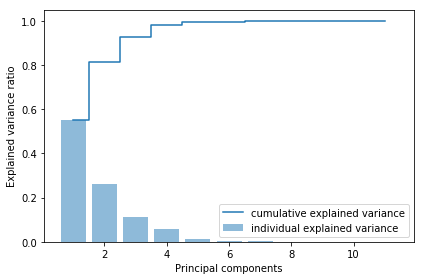

In [43]:
plot_explained_var(X_train, len(al))

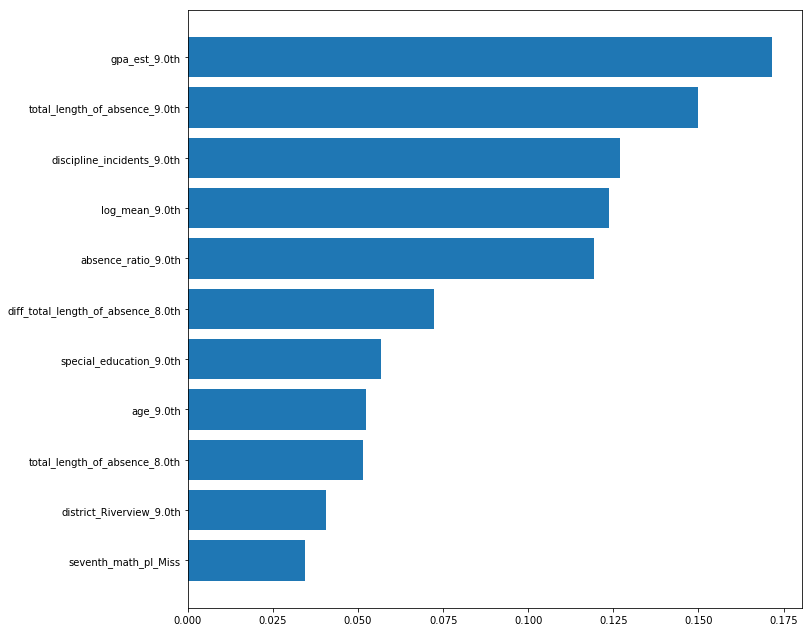

In [53]:
plot_importance(RF, x_train[al], y_train)

In [44]:
b = 'total_length_of_absence_9.0th,discipline_incidents_9.0th,absence_ratio_9.0th,diff_total_length_of_absence_8.0th,gpa_est_9.0th'

In [45]:
bl = b.split(',')

In [46]:
bl

['total_length_of_absence_9.0th',
 'discipline_incidents_9.0th',
 'absence_ratio_9.0th',
 'diff_total_length_of_absence_8.0th',
 'gpa_est_9.0th']

In [47]:
X_train2 = x_train[bl]
X_test2 = x_test[bl]


Eigenvalues 
[6.33466270e+01 3.36716632e+01 8.03235312e+00 1.74062530e+00
 1.10434328e-03]s


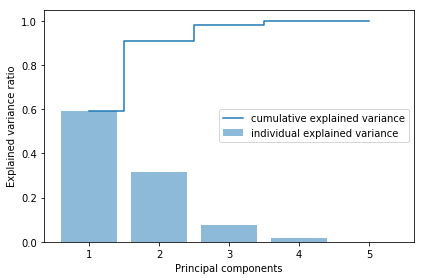

In [49]:
plot_explained_var(X_train2, len(bl))

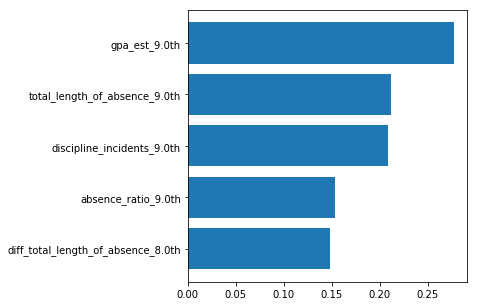

In [54]:
plot_importance(RF, x_train[bl], y_train)

In [55]:
bl

['total_length_of_absence_9.0th',
 'discipline_incidents_9.0th',
 'absence_ratio_9.0th',
 'diff_total_length_of_absence_8.0th',
 'gpa_est_9.0th']

In [ ]:
['total_length_of_absence_9.0th',
 'discipline_incidents_9.0th',
 'absence_ratio_9.0th',
 'gpa_est_9.0th',
 'log_mean_9.0th']